# Improving an LLM Agent Routine Using Meta-Prompting 

This notebook systematically **improves** an LLM Agent routine through an iterative, test-driven approach. By continuously refining the routine based on previous evaluations and the initial policy, we enhance the agent’s **accuracy, reasoning, and execution capabilities**.  

## Improvement Framework

To optimize the agent’s **decision-making and compliance**, we establish a structured loop where:  

1. **Initial Routine and Evaluation**  
   - The process begins with a **predefined policy** and an initial set of test cases.  
   - The routine is evaluated to assess the agent’s **interpretation, function execution, and accuracy**.  

2. **Iterative Routine Refinement**  
   - Based on the **previous evaluation results**, the routine is **regenerated** using meta-prompting.  
   - The updated routine incorporates insights from past failures to enhance performance.  

3. **Dual LLM Simulation**  
   - **User Simulator**: Simulates real-world user interactions based on structured test cases.  
   - **Agent Simulator**: The LLM agent follows the refined routine, processing user requests dynamically.  

4. **Conversational Interaction and Re-Evaluation**  
   - The **User Simulator** presents test queries.  
   - The **Agent Simulator** applies the improved routine to interpret requests and execute the correct function.  
   - The performance is **measured**, ensuring the agent correctly follows the refined routine.  

5. **Stopping Criteria**  
   - The loop continues **until the maximum iteration limit is reached** or **100% accuracy** is achieved.  

## Objectives  

- **Incrementally enhance the agent’s routine** by leveraging evaluation-driven refinements.  
- **Improve Execution Accuracy** by iterating on test failures and optimizing function calls.  
- **Ensure Maximum Compliance** by aligning the routine with structured reasoning and decision-making principles.  

<div align="center">
  <img src="images/improve_ai.png" alt="Meta-prompting Improve" width="800">
</div>

## Getting Started

Prerequisites:

- Python 3.11 or 3.12 installed on your system.
- LLM Agentic Tool Mesh library installed. If not, install it using: `pip install 'llmesh[chat, agetns]'`
- Install kernel for Jupiter notebook `pip install ipykernel`
- Create `.env` file inside `notebooks/data` folder with the value of `PYTHONPATH` and `OPENAI_API_KEY` environment variables

In [1]:
from dotenv import load_dotenv
import os

# Load environment variables from the .env file located in the Data folder
dotenv_path = os.path.join('data', '.env')
load_dotenv(dotenv_path)

# Read environment variables
python_path = os.getenv('PYTHONPATH')
if not python_path:
    raise ValueError("Project path is not set.")
llm_api_key = os.getenv('OPENAI_API_KEY')
if not llm_api_key:
    raise ValueError("API key is not set in environment variables.")

# Change working directory
os.chdir(python_path)

In [ ]:
import json
from notebooks.meta_prompting.utils import load_prompt, TOOLS, TOOL_CLOSE
from notebooks.meta_prompting.utils import read_policy

policy = read_policy()
tools = f"\n\n```json\n{json.dumps(TOOLS, indent=4)}\n```"
system_prompt = load_prompt('routine_improvment', {'policy': policy, 'tools':tools, 'tool_close': TOOL_CLOSE})

/Users/antoniofin/Documents/Code/llmesh/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2025-03-10 10:01:19,214 - ATHON - DEBUG - Prompt generated from notebooks/meta_prompting/prompts//routine_improvment.txt with params {'policy': "# **E-Commerce Customer Service Policy**\n\n**Purpose**: This document serves as a detailed guide for customer service representatives and support staff working in e-commerce. It provides structured guidelines for managing customer interactions, ensuring efficient issue resolution, maintaining service quality, optimizing response times, and handling user inquiries effectively.\n\n**Note**: Always follow best practices in customer support, compliance, and data security while managing customer interactions.\n\n## **Table of Contents**\n\n1. General Guidelines for Customer Service\n2. Order Management and Support\n3. Returns, Refunds, and Dispute Resolution\n4. FAQs for Common Scenarios\n\n### **1. General Guidelines for Customer Service**\n\n* **Monitor Customer Satisfaction**: Track key performance indicators (KPIs) such as response time, resol

In [ ]:
from notebooks.meta_prompting.utils import get_routine

routine = get_routine()

2025-03-10 10:01:19,218 - ATHON - INFO - Data loaded from notebooks/meta_prompting/files/output/ecommerce_agent_routine_0_cached.pkl.


In [ ]:
from notebooks.meta_prompting.utils import read_test_dataframe

test_dataframe = read_test_dataframe()

In [ ]:
from notebooks.meta_prompting.utils import read_result_dataframe

result_dataframe = read_result_dataframe()

## Improving the Routine

The routine is iteratively refined to enhance performance. Starting from the initial policy and the results of the previous evaluation, we **regenerate the routine** through meta-prompting, incorporating insights from past iterations.  

For each cycle, we evaluate the updated routine by simulating interactions between the **Agent and the Customer**, assessing the Agent’s ability to interpret requests, apply reasoning, and execute the correct function with the appropriate inputs. This process repeats until we either reach the maximum number of iterations or achieve **100% accuracy**.

In [ ]:
import pandas as pd
from notebooks.meta_prompting.utils import (
    generate_improve_messages,
    is_lower_than_max_tokens,
    improve_routine,
    evaluate_test_case,
    write_result_dataframe,
    are_results_cached,
    MAX_IMPROVMENT_LOOP,
    MIN_ACCURACY
)

results = {
    "routines": [routine],
    "results": [result_dataframe],
    "accuracies": [round(result_dataframe['Is Correct'].mean() * 100, 2)],
}
for i in range(MAX_IMPROVMENT_LOOP):
    messages = generate_improve_messages(results["results"], results["routines"], results["accuracies"], system_prompt)
    if is_lower_than_max_tokens(messages):
        if are_results_cached(i+1):
            result_dataframe = read_result_dataframe(i+1)
            new_routine = get_routine(i+1)
        else:
            # Get the updated routine from the metaprompting assistant
            new_routine = improve_routine(messages, i+1)
            records = []
            for row_number, test_row in test_dataframe.iterrows():
                print(f"Processing row: {row_number}")  
                record = evaluate_test_case(new_routine, test_row)
                records.append(record)
            result_dataframe = pd.DataFrame(records)
            write_result_dataframe(result_dataframe, i+1)
        accuracy = round(result_dataframe['Is Correct'].mean() * 100, 2)
        print(f"\nACCURACY-{i+1}: {accuracy}\n")
        results['routines'].append(new_routine)
        results['results'].append(result_dataframe)
        results['accuracies'].append(accuracy)
        if accuracy > MIN_ACCURACY:
            break

2025-03-10 10:01:19,242 - ATHON - INFO - Data loaded from notebooks/meta_prompting/files/output/ecommerce_agent_routine_1_cached.pkl.

ACCURACY-1: 72.22

2025-03-10 10:01:19,243 - ATHON - DEBUG - Prompt generated from notebooks/meta_prompting/prompts//evals_history.txt with params {}
2025-03-10 10:01:19,243 - ATHON - DEBUG - Selected Langchain ChatOpenAI
2025-03-10 10:01:26,306 - ATHON - DEBUG - Prompt generated [
  {
    "iteration": 2,
    "changes_made": "The modified routine shifted from a general inquiry classification method to a more detailed approach. Key changes include a warmer welcome, explicit confirmation of the inquiry type, clearer instructions on verifying essential details (like order ID and customer ID), and refined guidance for calling functions related to order management, returns, refunds, and account management.",
    "previous_accuracy": 44.44,
    "new_accuracy": 72.22,
    "impact": "Increase",
    "analysis": "The enhanced clarity and additional verification s

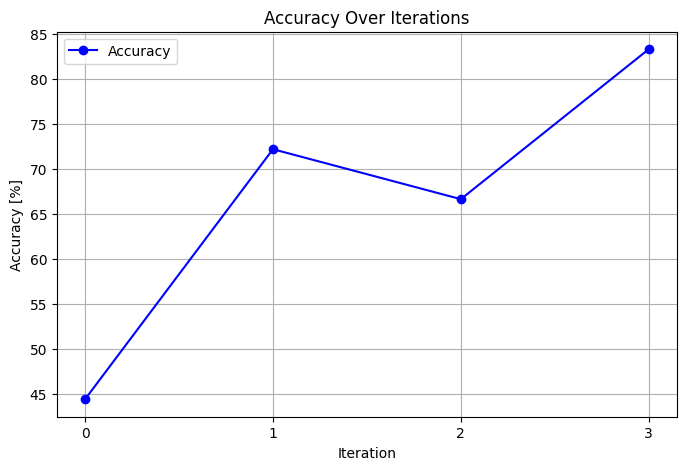

In [7]:
import matplotlib.pyplot as plt

# Assuming results is a dictionary containing 'accuracies' as a list
accuracies = results['accuracies']
iterations = list(range(len(accuracies)))  # Generate integer values for x-axis
# Plot
plt.figure(figsize=(8, 5))  # Set figure size
plt.plot(iterations, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
# Labels and Title
plt.xlabel("Iteration")
plt.ylabel("Accuracy [%]")
plt.title("Accuracy Over Iterations")
plt.xticks(iterations)  # Ensure only integer ticks are shown
plt.legend()
plt.grid(True)
# Show the plot
plt.show()

In [8]:
from IPython.display import HTML, Markdown

# Print last iteration accuracy
display(Markdown(f"## Accurancy: {accuracy}"))
# Print last iteration results
result_dataframe = result_dataframe.map(lambda x: x.replace("\n", "<br>") if isinstance(x, str) else x)
display(HTML(result_dataframe.to_html(escape=False)))

## Accurancy: 83.33

,Request,Context,Expected Function,Expected Inputs,Actual Function,Actual Inputs,Is Correct,Transcripts
0,What is the status of order 12345?,I want to check the status of my order.,get_order_status,{'order_id': '12345'},get_order_status,{'order_id': '12345.0'},False,"* User: What is the status of order 12345?* Assistant: Welcome! I can help you with that. Just to confirm, you are inquiring about the order status, correct? If so, I will proceed to check the status of order ID ""12345"". * User: Yes, that's correct. Please check the status of order ID 12345.* Assistant: * Tool: The order 12345 status: Order ID not found..* Assistant: It seems that the order ID ""12345"" is not found in our system. Could you please double-check the order ID and provide the correct one?* User: The order ID is 12345.0. Please check the status with this ID.* Assistant: * Tool: The order 12345.0 status: Order ID not found..* Assistant: It appears that the order ID ""12345.0"" is also not found in our system. Could you please verify the order ID once more? If you have any other details related to the order, that might help as well.* User: I have confirmed that the order ID is indeed ""12345.0."" Please check again for the status of this order.* Assistant: * Tool: The order 12345.0 status: Order ID not found..* Assistant: Unfortunately, the order ID ""12345.0"" is still not found in our system. It might be helpful to check if there are any typos or if the order ID is from a different account. If you have any other information or another order ID, please let me know, and I'll assist you further.* User: I understand that the order ID is ""12345.0,"" but it is still not found in our system. If you have any other details related to the order, such as the date it was placed or the email associated with the order, please provide that information so I can assist you better.* Assistant: Could you please provide the date the order was placed or the email associated with the order? This information may help in locating the order in our system.* User: I apologize for the confusion, but I don't have the date the order was placed or the email associated with it. I only have the order ID ""12345.0."" If there's anything else I can provide or if you have any other questions, please let me know.* Assistant: I understand. Unfortunately, without additional details or a valid order ID, I'm unable to locate the order in our system. If you happen to find any other information later, please feel free to reach out, and I'll be happy to assist you further.Is there anything else I can help you with today?* User: No, that will be all for now. Thank you for your assistance.* Assistant: * Tool: Close case for order: 12345.0"
1,Check the status of order 67890.,Can you tell me if my order has shipped?,get_order_status,{'order_id': '67890'},get_customer_order_history,{'customer_id': 'example@example.com'},False,"* User: Check the status of order 67890.* Assistant: Welcome! To assist you with your inquiry, could you please confirm that you would like to check the status of your order? If so, I will proceed with the order ID you provided.* User: Yes, I would like to check the status of my order with ID 67890.* Assistant: * Tool: The order 67890 status: Order ID not found..* Assistant: It seems that the order ID 67890 is not found in our system. Could you please double-check the order ID and provide the correct one?* User: The order ID is 67890.0.* Assistant: Could you please confirm if the order ID is indeed ""67890.0"" or if it should be ""67890""? The format seems to include a decimal, which may not be correct. Please clarify so I can assist you further.* User: The order ID is 67890.0.* Assistant: * Tool: The order 67890.0 status: Order ID not found..* Assistant: It appears that the order ID ""67890.0"" is also not found in our system. Could you please verify the order ID once more or provide any additional details that might help?* User: I have confirmed that the order ID is 67890.

## Next Steps

In the next notebook ([**07: Conclusion**](07_Conclusion.ipynb)), we will explore how to build an AI-powered agent tailored to your specific use case. Additionally, we will cover the integration of the agent into a chatbot.